In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import matplotlib.pyplot as plt
from numpy.lib.stride_tricks import as_strided
import torch
import torch.nn.functional as F
import copy
# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/mnist-in-csv/mnist_test.csv
/kaggle/input/mnist-in-csv/mnist_train.csv


In [2]:
data = pd.read_csv("/kaggle/input/mnist-in-csv/mnist_train.csv").reset_index(drop=True)
Y = data["label"].to_numpy()
X = data.drop("label", axis=1).to_numpy()
X = X.reshape(-1, 1, 28, 28)

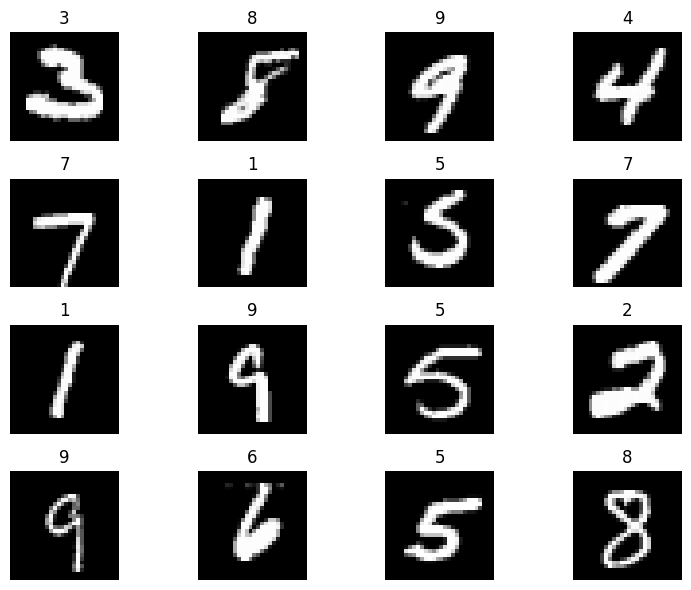

In [3]:
dimension = 4
ints = np.random.randint(0, X.shape[0], dimension**2, dtype=int)
fig, axes = plt.subplots(dimension, dimension, figsize=(8, 6))
axes = axes.ravel()
for i in range(dimension**2):
    axes[i].imshow(X[ints[i], 0, :, :], cmap='gray')  
    axes[i].set_title(Y[ints[i]])
    axes[i].axis('off')  

plt.tight_layout()
plt.show()

In [4]:
class CNN():
    def __init__(self, X, Y):
        new = np.zeros((10, Y.shape[0]))
        new[Y, range(Y.shape[0])] = 1
        self.X = X     
        self.Y = new
        self.filters = []
        self.alpha, self.beta = [], []
        self.W = []
        self.B = []
        self.activation = []
        self.old_W, self.old_B, self.old_filter, self.old_alpha, self.old_beta = [], [], [], [], []
        self.old_WS, self.old_BS, self.old_filterS, self.old_alphaS, self.old_betaS = [], [], [], [], []
        self.t = 0
        
    def create_mini_batch(self, size = 64):
        indices = np.random.choice(self.X.shape[0], size=size, replace=False)
        self.X_B = self.X[indices]
        self.Y_B = self.Y[:, indices]
    
    def create_filter_layer(self, filter_dims = (5, 1, 3, 3)):
        if not self.filters:
            if self.X_B.shape[1] != filter_dims[1]:
                raise Exception("The filter dimensions do not match")
            he_number = np.sqrt(2 / np.prod(filter_dims[2:]))
            self.filters.append(np.random.randn(*filter_dims))
            self.old_filter.append(np.zeros((filter_dims)))
            self.old_filterS.append(np.zeros((filter_dims)))
        else:
            if self.filters[-1].shape[0] != filter_dims[1]:
                raise Exception("The filter dimensions do not match")
            he_number = np.sqrt(2 / np.prod(filter_dims[2:]))
            self.filters.append(np.random.randn(*filter_dims))
            self.old_filter.append(np.zeros((filter_dims)))
            self.old_filterS.append(np.zeros((filter_dims)))
            
    def calculate_input_size(self):
        if self.filters:
            starting_dims = self.X_B.shape[2]
            for i in self.filters:
                starting_dims -= i.shape[2]
                starting_dims += 1
            return starting_dims**2 * i.shape[0]
        else:
            raise Exception("There are no filters")
            
        
    def padding(self,Z, padding =2):
        return np.pad(Z, pad_width=((0,0), (0,0), (padding,padding), (padding,padding)))
        
    def fully_connected_layer(self, layer_depth=10, activation="ReLU"):
        if not self.W:
            he_number = np.sqrt(2/ self.calculate_input_size())
            self.W.append(np.random.randn(layer_depth, self.calculate_input_size()) * 10 )
            self.B.append(np.random.randn(layer_depth, 1))
            self.alpha.append(np.ones((layer_depth, 1)))
            self.beta.append(np.zeros((layer_depth, 1)))
            self.activation.append(activation)
            self.old_W.append(np.zeros((layer_depth, self.calculate_input_size())))
            self.old_B.append(np.zeros((layer_depth, 1)))
            self.old_alpha.append(np.zeros((layer_depth, 1)))
            self.old_beta.append(np.zeros((layer_depth, 1)))
            self.old_WS.append(np.zeros((layer_depth, self.calculate_input_size())))
            self.old_BS.append(np.zeros((layer_depth, 1)))
            self.old_alphaS.append(np.zeros((layer_depth, 1)))
            self.old_betaS.append(np.zeros((layer_depth, 1)))
        else:
            he_number = np.sqrt(2/ self.W[-1].shape[0])
            self.W.append(np.random.randn(layer_depth, self.W[-1].shape[0]) * 10)
            self.B.append(np.random.randn(layer_depth, 1))
            self.alpha.append(np.ones((layer_depth, 1)))
            self.beta.append(np.zeros((layer_depth, 1)))
            self.activation.append(activation)
            self.old_W.append(np.zeros((layer_depth, self.W[-2].shape[0])))
            self.old_B.append(np.zeros((layer_depth, 1)))
            self.old_alpha.append(np.zeros((layer_depth, 1)))
            self.old_beta.append(np.zeros((layer_depth, 1)))
            self.old_WS.append(np.zeros((layer_depth, self.W[-2].shape[0])))
            self.old_BS.append(np.zeros((layer_depth, 1)))
            self.old_alphaS.append(np.zeros((layer_depth, 1)))
            self.old_betaS.append(np.zeros((layer_depth, 1)))
    def convolution(self,Z, f):
        N, C, H, W = Z.shape
        NS, CS, HS, WS = Z.strides
        C_out, _, f_K, f_K = f.shape
        C_outs, _, _, FWS = f.strides
        f = np.ascontiguousarray(as_strided(f, shape=(C*f_K**2, C_out), strides=(FWS, C_outs)))
        inner_dims = f_K * f_K * C
        A = as_strided(Z, shape=(N, H-f_K+1, W-f_K+1, C, f_K, f_K)
                      , strides = (NS, HS, WS, CS, HS, WS)).reshape(-1, inner_dims)
        out = A @ f
        S, E = out.strides
        out = as_strided(out, shape=(N, C_out, (H-f_K+1)*(W-f_K+1)), strides=(E*(W-f_K+1)*(H-f_K+1)*C_out, E, S )).reshape(N, C_out, H-f_K+1, W-f_K+1)
        return out
    def convolution_backward(self,Z, dZ, f):
        N, _, H, H = dZ.shape
        dNs, dCs, dHs, dHs = dZ.strides
        N, C_in , _, _= Z.shape
        NS, CS, HS, WS = Z.strides
        C_out, f_C_in, f_K, f_K = f.shape
        inner_dims = H * H * N
        dZ = as_strided(dZ, shape = (C_out, N, H**2), strides=(dCs, dNs ,dHs)).reshape(C_out, inner_dims)
        Z = as_strided(Z, shape=(C_in, f_K, f_K,N, H, H), strides=(CS, HS, WS, NS, HS, WS)).reshape(-1,inner_dims).T
        out =  dZ @ Z 
        return out.reshape(f.shape)
    def convolution_backward_Z(self, dZ, f):
        dZ = self.padding(dZ)
        N, C, H, W = dZ.shape
        NS, CS, HS, WS = dZ.strides
        f = np.rot90(f, k=2, axes=(2, 3))
        _, f_C_in, f_K, f_K = f.shape
        inner_dims = f_K * f_K
        f = f.reshape(C, f_C_in, f_K**2)
        dZ = as_strided(dZ, shape=(C, N, H-2, W-2,f_K, f_K), strides=(CS, NS, HS, WS, HS, WS)).reshape(C, -1 , inner_dims)
        out = np.zeros((N, f_C_in, H-2, W-2))
        for c in range(C):
            nout = dZ[c] @ f[c].T
            out_s, out_e = nout.strides
            out += np.ascontiguousarray(as_strided(nout, shape=(N, f_C_in, H-2, W-2), strides=(out_e * f_C_in*(H-2)*(W-2), out_e, out_s * (W-2), out_s)))
        return  out
    def batch_norm(self, Z):
        mean = np.mean(Z, axis=1, keepdims=True)
        var = np.var(Z, axis=1, keepdims=True)
        out = (Z - mean) / np.sqrt(var+1e-8)
        return out, mean, var
    def batch_norm_backward(self,Z, PB, alpha, mean, var, dZ):
        dalpha = np.sum(dZ * PB, axis=1, keepdims=True)
        dbeta = np.sum(dZ, axis=1, keepdims = True)
        dPB = dZ * alpha
        dvar = np.sum(dPB * (Z - mean) * ( (-1/2) * (var+1e-8)**(-3/2) ), axis=1, keepdims=True)
        dmean = np.sum(dPB * (-1/np.sqrt(var + 1e-8)), axis=1, keepdims=True) + dvar * (np.sum(-2*(Z - mean), axis=1, keepdims=True)/Z.shape[1])
        dZ = dPB * (1/np.sqrt(var + 1e-8)) + dvar * ((2*(Z - mean))/Z.shape[1]) + dmean / Z.shape[1]
        return dZ, dalpha, dbeta
    def activations(self,Z, activation):
        if activation == "ReLU":
            return Z  * (Z > 0)
        if activation == "softmax":
            return np.exp(Z - np.max(Z, axis=0, keepdims=True) + 1e-8) / np.sum(np.exp(Z - np.max(Z, axis=0, keepdims=True)+ 1e-8), axis = 0, keepdims = True)
    def calculate_loss(self,Z):
        self.loss = -np.mean(np.sum(np.log(Z + 1e-8) * self.Y_B, axis=0))
    def forward(self):
        self.Z_filter = [0 for i in range(len(self.filters))]
        self.A_filter = [0 for i in range(len(self.filters))]
        self.Z = [0 for i in range(len(self.W))]
        self.PB, self.PA = [0 for i in range(len(self.W))], [0 for i in range(len(self.W))]
        self.A = [0 for i in range(len(self.W))]
        self.mean, self.var = [0 for i in range(len(self.W))], [0 for i in range(len(self.W))]
        
        self.Z_filter[0] = self.convolution(self.X_B, self.filters[0])
        self.A_filter[0] = self.Z_filter[0] * (self.Z_filter[0] > 0)
        for i in range(1, len(self.filters)):
            self.Z_filter[i] = self.convolution(self.A_filter[i-1], self.filters[i])
            self.A_filter[i] = self.Z_filter[i] * (self.Z_filter[i] > 0)
        self.Z[0] = self.W[0] @ self.A_filter[-1].reshape(-1, self.calculate_input_size()).T + self.B[0]
        self.PB[0], self.mean[0], self.var[0] = self.batch_norm(self.Z[0])
        self.PA[0] = self.PB[0] * self.alpha[0] + self.beta[0]
        self.A[0] = self.activations(self.PA[0], self.activation[0])
        for i in range(1,len(self.W)):
            self.Z[i] = self.W[i] @ self.A[i-1] + self.B[i]
            self.PB[i], self.mean[i], self.var[i] = self.batch_norm(self.Z[i])
            self.PA[i] = self.PB[i] * self.alpha[i] + self.beta[i]
            self.A[i] = self.activations(self.PA[i], self.activation[i])
        self.calculate_loss(self.A[-1])

    def backward(self):
        num = len(self.W) - 1
        self.dW, self.dB, self.dfilter = [0 for i in range(len(self.W))], [0 for i in range(len(self.W))], [0 for i in range(len(self.filters))]
        self.dalpha, self.dbeta = [0 for i in range(len(self.W))], [0 for i in range(len(self.W))]
        dZ = (self.A[-1] - self.Y_B) / self.Y_B.shape[1]
        dZ, self.dalpha[num], self.dbeta[num] = self.batch_norm_backward(self.Z[num], self.PB[num], self.alpha[num], self.mean[num], self.var[num], dZ)
        self.dW[num] = dZ @ self.A[num-1].T 
        self.dB[num] = np.sum(dZ, axis=1, keepdims=True)
        dZ = (self.W[num].T @ dZ) * (self.PA[num-1] > 0)
        for i in range(num-1, 0, -1):
            dZ, self.dalpha[i], self.dbeta[i] = self.batch_norm_backward(self.Z[i], self.PB[i], self.alpha[i], self.mean[i], self.var[i], dZ) 
            self.dW[i] = dZ @ self.A[i-1].T
            self.dB[i] = np.sum(dZ, axis=1, keepdims=True)
            dZ = (self.W[i].T @ dZ) * (self.PA[i-1] > 0)
        dZ, self.dalpha[0], self.dbeta[0] = self.batch_norm_backward(self.Z[0], self.PB[0], self.alpha[0], self.mean[0], self.var[0], dZ)
        self.dW[0] = dZ @ self.A_filter[-1].reshape(-1, self.calculate_input_size())
        dZ = (self.W[0].T @ dZ).T.reshape(self.A_filter[-1].shape) * (self.Z_filter[-1] > 0)
        for i in range(len(self.filters) -1, 0, -1):
            self.dfilter[i] = self.convolution_backward(self.A_filter[i-1], dZ, self.filters[i])
            dZ = self.convolution_backward_Z(dZ, self.filters[i]) * (self.Z_filter[i-1] > 0)
        self.dfilter[0] = self.convolution_backward(self.X_B, dZ, self.filters[0])

    def adam(self, beta1 = 0.9, beta2 = 0.999):
        self.t +=1
        for i in range(len(self.filters)):
            self.old_filter[i] = (self.old_filter[i] * beta1 + self.dfilter[i] * (1 - beta1)) 
            self.old_filterS[i] = (self.old_filterS[i] * beta1 + self.dfilter[i]**2 * (1 - beta2)) 
            self.dfilter[i] = self.old_filter[i] / np.sqrt(self.old_filterS[i] + 1e-8)
            
        for i in range(len(self.W)):
            self.old_W[i] = (self.old_W[i] * beta1 + self.dW[i] * (1 -beta1)) 
            self.old_B[i] = (self.old_B[i] * beta1 + self.dB[i] * (1 -beta1)) 
            self.old_alpha[i] = (self.old_alpha[i] * beta1 + self.dalpha[i] * (1 -beta1)) 
            self.old_beta[i] = (self.old_beta[i] * beta1 + self.dbeta[i] * (1 -beta1)) 
            self.old_WS[i] = (self.old_WS[i] * beta2 + self.dW[i]**2 * (1 -beta2)) 
            self.old_BS[i] = (self.old_BS[i] * beta2 + self.dB[i]**2 * (1 -beta2)) 
            self.old_alphaS[i] = (self.old_alphaS[i] * beta2 + self.dalpha[i]**2 * (1 -beta2)) 
            self.old_betaS[i] = (self.old_betaS[i] * beta2 + self.dbeta[i]**2 * (1 -beta2)) 
            self.dW[i] = self.old_W[i] / np.sqrt(self.old_WS[i] + 1e-8)
            self.dB[i] = self.old_B[i] / np.sqrt(self.old_BS[i] + 1e-8)
            self.dalpha[i] = self.old_alpha[i] / np.sqrt(self.old_alphaS[i] + 1e-8)
            self.dbeta[i] = self.old_beta[i] / np.sqrt(self.old_betaS[i] + 1e-8)
            
            
    def update(self, learning_rate=0.01):
        for i in range(len(self.filters)):
            self.filters[i] = self.filters[i] - learning_rate * self.dfilter[i]
        for i in range(len(self.W)):
            self.W[i] = self.W[i] - learning_rate * self.dW[i]
            self.B[i] = self.B[i] - learning_rate * self.dB[i]
            self.alpha[i] = self.alpha[i] - learning_rate * self.dalpha[i]
            self.beta[i] = self.beta[i] - learning_rate * self.dbeta[i]
            
        
            
        
        
        
        
            
            
            
                
                
            



In [46]:
nn = CNN(X, Y)
nn.create_mini_batch()
nn.create_filter_layer()
nn.create_filter_layer(filter_dims = (32, 5, 3, 3))
nn.create_filter_layer(filter_dims = (64, 32, 3, 3))
nn.fully_connected_layer(layer_depth=64, activation="ReLU")
nn.fully_connected_layer(layer_depth=32, activation="ReLU")
nn.fully_connected_layer(layer_depth=10, activation="softmax")
nn.forward()
nn.backward()
old_loss = nn.loss
nn.filters[1][7, 2, 2, 0] += 1e-4
nn.forward()
print("manually calculated loss:",(nn.loss - old_loss)/ 1e-4,
      "\nnetwork calculated loss", nn.dfilter[1][7, 2, 2, 0],
     "\ndifference", np.absolute((nn.loss - old_loss)/ 1e-4 - nn.dfilter[1][7, 2, 2, 0]))

manually calculated loss: -0.008586272555177743 
network calculated loss -0.00858617686495287 
difference 9.569022487235235e-08


In [51]:
l = 1e-6
d = 0
loss_values = np.zeros((10))
for i in range(1000):
    nn.forward()
    nn.backward()
    nn.adam()
    nn.update(learning_rate=lo)
    nn.create_mini_batch()
    loss_values[d] = nn.loss
    d+= 1
    if d % 10 == 0:
        print(np.median(loss_values))
        d = 0
        

0.14020006947834568
0.13789290895026643
0.11505960997198277
0.09515804003142248
0.1401824504790019
0.18542038578275552
0.09228214419849987
0.11749411782486394
0.08177168265753185
0.11242914133576762
0.10405838721931321


KeyboardInterrupt: 

In [54]:
nn.create_mini_batch()
nn.forward()
values = np.argmax(nn.A[-1], axis=0)
new_mat = np.zeros((10, 64))
new_mat[values, range(64)] = 1
num_differences = np.sum(nn.Y_B != new_mat)
print(f"accuracy:{(64 - num_differences)/64}, correct:{(64 - num_differences)}/64")


accuracy:0.96875, correct:62/64


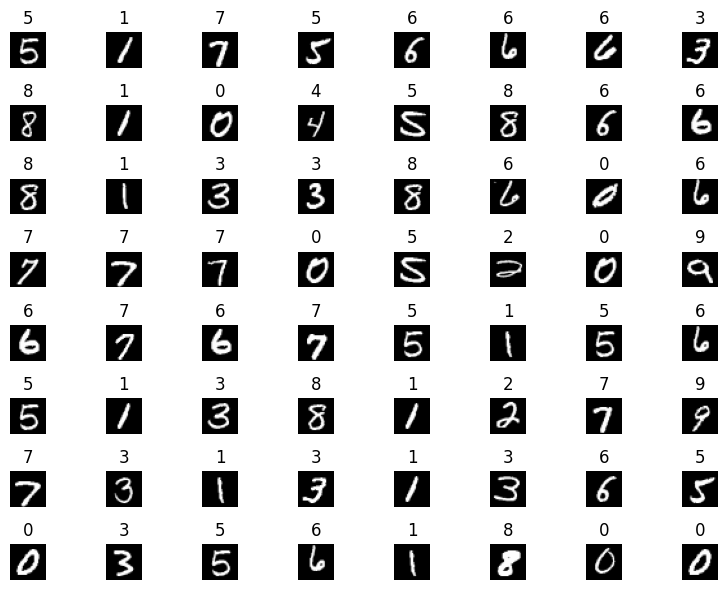

In [58]:
dimension = 8
ints = np.random.randint(0, nn.X_B.shape[0], dimension**2, dtype=int)
fig, axes = plt.subplots(dimension, dimension, figsize=(8, 6))
axes = axes.ravel()
for i in range(dimension**2):
    axes[i].imshow(nn.X_B[ints[i], 0, :, :], cmap='gray')  
    axes[i].set_title(values[ints[i]])
    axes[i].axis('off')  

plt.tight_layout()
plt.show()